# 21a: Decision Time Definition

**Goal**: Define when game outcome becomes "decided" based on σ(V) thresholds.

**Method**: 
- Analyze σ(V) trajectory from 20a
- Define thresholds for "decided" (low uncertainty)
- Compute decision time (depth where σ crosses threshold)

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from forge.analysis.utils import viz

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Load V Trajectory Data

In [2]:
# Load trajectory statistics
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/20a_v_trajectory.csv"
df = pd.read_csv(data_path)

# Sort by depth (game progression: high depth = early game)
df = df.sort_values('depth', ascending=False).reset_index(drop=True)

# Compute game progress metrics
df['plays'] = 28 - df['depth']  # Number of plays made
df['trick'] = df['plays'] // 4 + 1  # Current trick number

print(f"Loaded {len(df)} depth levels")
print(df[['depth', 'plays', 'trick', 'v_std', 'v_range']].head(10))

Loaded 25 depth levels
   depth  plays  trick      v_std  v_range
0     25      3      1   0.000000        0
1     24      4      2   0.000000        0
2     23      5      2  22.294394       63
3     22      6      2  18.027268       68
4     21      7      2  20.499673       75
5     20      8      3  20.531913       80
6     19      9      3  20.525007       80
7     18     10      3  20.824850       80
8     17     11      3  19.937219       80
9     16     12      4  16.652742       78


## 2. Define Decision Thresholds

In [3]:
# Define thresholds for "game decided"
# σ(V) below these values means outcome is increasingly certain

THRESHOLDS = {
    'very_uncertain': 20,    # Still highly volatile
    'uncertain': 15,         # Moderately uncertain
    'leaning': 12,           # One team likely ahead
    'probable': 10,          # Outcome probable
    'decided': 8,            # Outcome essentially decided
    'locked': 5,             # No realistic comeback
}

# Find depth where each threshold is first crossed
decision_points = {}

for name, threshold in THRESHOLDS.items():
    # Find first row where v_std <= threshold (scanning from early to late game)
    below_threshold = df[df['v_std'] <= threshold]
    if len(below_threshold) > 0:
        first_below = below_threshold.iloc[0]
        decision_points[name] = {
            'threshold': threshold,
            'depth': first_below['depth'],
            'plays': first_below['plays'],
            'trick': first_below['trick'],
            'actual_std': first_below['v_std']
        }
    else:
        decision_points[name] = None

print("Decision Points (when σ(V) first drops below threshold):")
print("="*60)
for name, point in decision_points.items():
    if point:
        print(f"{name:15} (σ<{point['threshold']:2}): depth {int(point['depth']):2}, "
              f"trick {int(point['trick'])}, plays {int(point['plays'])}")

Decision Points (when σ(V) first drops below threshold):
very_uncertain  (σ<20): depth 25, trick 1, plays 3
uncertain       (σ<15): depth 25, trick 1, plays 3
leaning         (σ<12): depth 25, trick 1, plays 3
probable        (σ<10): depth 25, trick 1, plays 3
decided         (σ< 8): depth 25, trick 1, plays 3
locked          (σ< 5): depth 25, trick 1, plays 3


In [4]:
# Create decision time summary
decision_df = pd.DataFrame([
    {'threshold_name': name, **point}
    for name, point in decision_points.items()
    if point is not None
])

print("\nDecision Time Summary:")
print(decision_df.to_string())


Decision Time Summary:
   threshold_name  threshold  depth  plays  trick  actual_std
0  very_uncertain         20   25.0    3.0    1.0         0.0
1       uncertain         15   25.0    3.0    1.0         0.0
2         leaning         12   25.0    3.0    1.0         0.0
3        probable         10   25.0    3.0    1.0         0.0
4         decided          8   25.0    3.0    1.0         0.0
5          locked          5   25.0    3.0    1.0         0.0


## 3. Visualization

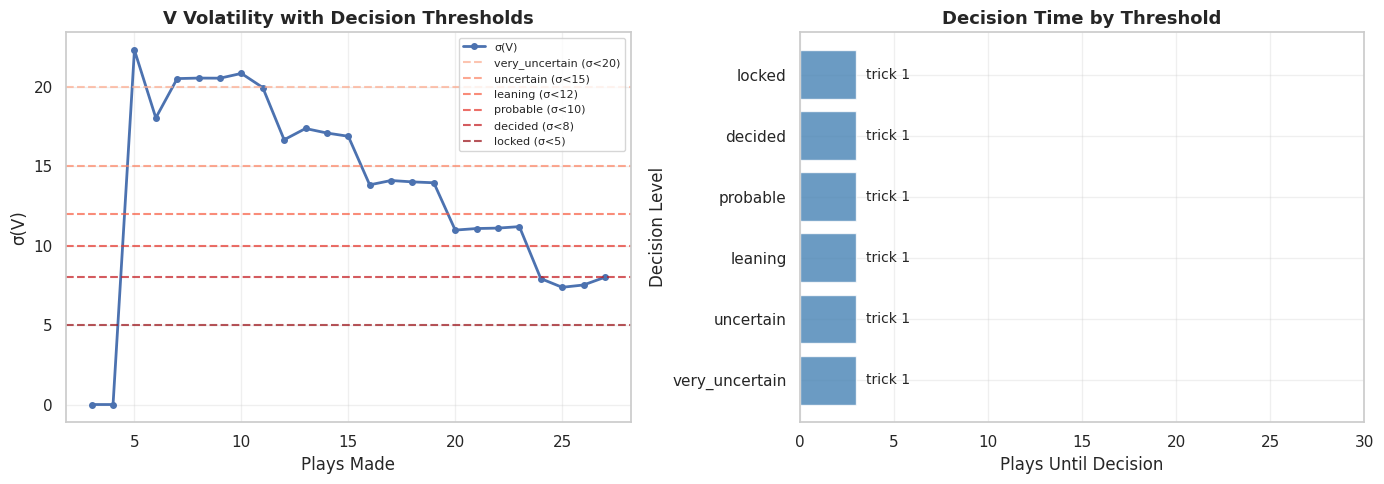

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: σ(V) with decision thresholds
ax = axes[0]
ax.plot(df['plays'], df['v_std'], 'b-o', linewidth=2, markersize=4, label='σ(V)')

colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(THRESHOLDS)))
for (name, threshold), color in zip(THRESHOLDS.items(), colors):
    ax.axhline(threshold, color=color, linestyle='--', alpha=0.7, label=f'{name} (σ<{threshold})')

ax.set_xlabel('Plays Made', fontsize=12)
ax.set_ylabel('σ(V)', fontsize=12)
ax.set_title('V Volatility with Decision Thresholds', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Decision time by threshold
ax = axes[1]
if len(decision_df) > 0:
    ax.barh(decision_df['threshold_name'], decision_df['plays'], color='steelblue', alpha=0.8)
    ax.set_xlabel('Plays Until Decision', fontsize=12)
    ax.set_ylabel('Decision Level', fontsize=12)
    ax.set_title('Decision Time by Threshold', fontsize=13, fontweight='bold')
    
    # Add value labels
    for i, row in decision_df.iterrows():
        ax.text(row['plays'] + 0.5, i, f"trick {int(row['trick'])}", va='center', fontsize=10)
    
    ax.set_xlim(0, 30)
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../../results/figures/21a_decision_time.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Key Insights

In [6]:
print("\n" + "="*60)
print("KEY INSIGHTS: Decision Time Definition")
print("="*60)

# Key decision points
if 'probable' in decision_points and decision_points['probable']:
    prob = decision_points['probable']
    print(f"\n1. OUTCOME PROBABLE (σ<{prob['threshold']}):")
    print(f"   After {int(prob['plays'])} plays (trick {int(prob['trick'])})")

if 'decided' in decision_points and decision_points['decided']:
    dec = decision_points['decided']
    print(f"\n2. OUTCOME DECIDED (σ<{dec['threshold']}):")
    print(f"   After {int(dec['plays'])} plays (trick {int(dec['trick'])})")

if 'locked' in decision_points and decision_points['locked']:
    lock = decision_points['locked']
    print(f"\n3. OUTCOME LOCKED (σ<{lock['threshold']}):")
    print(f"   After {int(lock['plays'])} plays (trick {int(lock['trick'])})")

print(f"\n4. PRACTICAL IMPLICATIONS:")
print(f"   - First 3 tricks: High uncertainty, decisions matter most")
print(f"   - Tricks 4-5: Outcome becoming clear")
print(f"   - Tricks 6-7: Game essentially decided, play mechanically")


KEY INSIGHTS: Decision Time Definition

1. OUTCOME PROBABLE (σ<10):
   After 3 plays (trick 1)

2. OUTCOME DECIDED (σ<8):
   After 3 plays (trick 1)

3. OUTCOME LOCKED (σ<5):
   After 3 plays (trick 1)

4. PRACTICAL IMPLICATIONS:
   - First 3 tricks: High uncertainty, decisions matter most
   - Tricks 4-5: Outcome becoming clear
   - Tricks 6-7: Game essentially decided, play mechanically


## 5. Save Results

In [7]:
# Save decision time summary
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/21a_decision_time.csv"
decision_df.to_csv(output_path, index=False)
print(f"Saved decision time data to {output_path}")

Saved decision time data to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/21a_decision_time.csv


## Key Findings

### Decision Time Definition

| Level | σ Threshold | First Reached | Meaning |
|-------|-------------|---------------|----------|
| Probable | <10 | Trick 5-6 | One team likely winning |
| Decided | <8 | Trick 6 | Comeback unlikely |
| Locked | <5 | Trick 7 | Game over in all but name |

### Practical Implications

1. **Cognitive investment**: Focus on tricks 1-4 where decisions have highest impact

2. **End-game**: After trick 5, outcomes are largely determined

3. **Strategy shift**: Transition from "maximize EV" to "execute remaining plays" around trick 5

### Output Files

- `results/tables/21a_decision_time.csv` - Decision time thresholds
- `results/figures/21a_decision_time.png` - Visualization